In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, RBF, WhiteKernel
# from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from modAL.models import ActiveLearner, BayesianOptimizer
# from modAL.acquisition import max_EI, optimizer_EI
from modAL.uncertainty import uncertainty_sampling
import pandas as pd

# Active learning in 3D

## Define functions to use

In [2]:
def sample_initial_training_points(data):
    X_raw = np.stack((data['Pipe_D'].astype('float'), 
                      data['Elbow angle'].astype('float'), 
                      data['Inlet_V'].astype('float')), axis=-1)
    y_raw = np.array(data['Del_P'].astype('float'))

    # Isolate our examples for labeled dataset.
    n_labeled_examples = X_raw.shape[0]
    training_indices = np.random.randint(low=0, high=n_labeled_examples, size=3)
    # training_indices = [0, -1, 2000]

    X_train = X_raw[training_indices]
    y_train = y_raw[training_indices]

    # Isolate the non-training examples we'll be querying.
    X_pool = np.delete(X_raw, training_indices, axis=0)
    y_pool = np.delete(y_raw, training_indices, axis=0)

    return X_train, y_train, X_pool, y_pool

In [3]:
def GP_regression_std(regressor, X):
    _, std = regressor.predict(X, return_std=True)
    query_idx = np.argmax(std)
    print(np.max(std))
    return query_idx, X[query_idx]

def active_learner(X_train, y_train):
    kernel = Matern(length_scale=[0.1, 0.1, 0.1]) 
    regressor = GaussianProcessRegressor(kernel=kernel, normalize_y=True, n_restarts_optimizer=64)

    regressor_3d = ActiveLearner(
        estimator=regressor,
        query_strategy=GP_regression_std, #max_EI,
        X_training=X_train, y_training=y_train
    )
    return regressor_3d

In [ ]:
# come up with distributions
D = np.linspace(0.005, 0.1, 1000)
angle = np.linspace(1, 180, 1000, endpoint=False)
vin = np.linspace(0.025, 0.005, 1000)
x = np.column_stack((D, angle, vin))

In [ ]:
pred_init, std_init = regressor_3d.predict(x.reshape(-1,3), return_std = True) 

with plt.style.context('seaborn-white'):
    plt.figure(figsize=(8, 5))
    plt.plot(x[:,1], pred_init, label='predicted')
    plt.fill_between(x[:, 1], pred_init-std_init, pred_init+std_init, alpha=0.2)
    plt.scatter(X_train[:,1], y_train, c='k', label='Analytic func') # label='CFD calc')
    plt.title('Initial Estimation')
    plt.xlabel('Bend Angle')
    plt.ylabel(r'Predicted $\Delta P/L$')
    plt.legend()
    plt.show()
    plt.savefig('Init_known_func.svg')

In [8]:
def query_data(N_QUERIES, X_pool, y_pool, regressor_3d):
    #performance_history = [unqueried_score]
    Xs = np.empty((1,3))
    ys = np.empty((1))
    # Allow our model to query our unlabeled dataset for the most
    # informative points according to our query strategy (uncertainty sampling).
    for index in range(N_QUERIES):
        query_index, query_instance = regressor_3d.query(X_pool)

        # Teach our ActiveLearner model the record it has requested.
        X, y = X_pool[query_index].reshape(-1, 3), y_pool[query_index].reshape(1, )
        print(X, y)
        regressor_3d.teach(X=X, y=y)

        # Remove the queried instance from the unlabeled pool.
        Xs = np.append(Xs, X, axis=0)
        ys = np.append(ys, y, axis=0)
        X_pool, y_pool = np.delete(X_pool, query_index, axis=0), np.delete(y_pool, query_index)

        # Calculate and report our model's accuracy.
        model_accuracy = regressor_3d.estimator.score(Xs.reshape(-1,3), ys.reshape(-1, 1))
        print('Accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))
    
    return Xs[1:], ys[1:], X_pool, y_pool, model_accuracy


In [5]:
def create_train_dat(N_QUERIES, Xs, ys, iteration=0):
    directory = f'cfd-sr-dim/active_learning/points{N_QUERIES}_{iteration}/'
    if not os.path.exists(directory):
        os.makedirs(directory)
    # print(Xs, ys)
    df = pd.DataFrame.from_dict({'Pipe_D': Xs[:,0], 'Elbow angle': Xs[:, 1], 'Inlet_V': Xs[:, 2], 'Del_P': ys})
    df['angle'] = np.round(np.radians(df['Elbow angle']), decimals=4)
    df['Density'] = np.ones(df.shape[0]) * 998.
    df['Viscosity'] = np.ones(df.shape[0]) * 0.0009737

    df.to_csv(directory + 'train.dat', sep=' ', 
                  columns=['Del_P', 'Pipe_D', 'angle', 'Inlet_V', 'Density', 'Viscosity'],
                  index=True, index_label='materials')
    sisso = f'''!_________________________________________________________________
! keywords for the target properties
!_________________________________________________________________
ptype=1
ntask=1
nsample={df.shape[0]}                           ! number of samples for each task
task_weighting=1
desc_dim=3                            ! dimension of the descriptor
restart=.false.                       ! set .true. to continue a job that was stopped but not yet finished
!_________________________________________________________________
!keywords for feature construction and sure independence screening
!_________________________________________________________________
nsf=5                                 ! number of scalar features (one feature is one number for each material)
rung=2                                ! rung (<=3) of the feature space to be constructed (times of applying the opset recursively)
opset='(+)(-)(*)(/)(exp)(exp-)(sin)(cos)'
maxcomplexity=5                      ! max feature complexity (number of operators in a feature)
dimclass=(1:1)(2:2)(3:3)(4:5)              ! group features according to their dimension/unit; those not in any () are dimensionless
maxfval_lb=1e-6                       ! features having the max. abs. data value < maxfval_lb will not be selected
maxfval_ub=1e4                        ! features having the max. abs. data value > maxfval_ub will not be selected
subs_sis=2000                          ! size of the SIS-selected (single) subspace for each descriptor dimension
!_________________________________________________________________
!keywords for descriptor identification via a sparsifying operator
!_________________________________________________________________
method='L0'                           ! sparsification operator: 'L1L0' or 'L0'; L0 is recommended!
fit_intercept=.false.                 ! fit to a nonzero intercept (.true.) or force the intercept to zero (.false.)
metric='RMSE'                         ! for regression only, the metric for model selection: RMSE,MaxAE
nm_output=100                          ! number of the best models to output'''

    with open(directory + 'SISSO.in', 'w') as f:
        f.write(sisso)
    
    return directory

In [6]:
def create_test_dat(directory, X_pool, y_pool):
    df = pd.DataFrame.from_dict({'Pipe_D': X_pool[:,0], 'Elbow angle': X_pool[:, 1], 'Inlet_V': X_pool[:, 2], 'Del_P': y_pool})
    df['angle'] = np.round(np.radians(df['Elbow angle']), decimals=4)
    df['Density'] = np.ones(df.shape[0]) * 998
    df['Viscosity'] = np.ones(df.shape[0]) * 0.0009737
    df['func'] = np.ones(df.shape[0])
    # dimensionless groups from buckingham pi theorem
    # df['pi1'] = df['Del_P'] * df['Pipe_D']**2 * df['Density'] / df['Viscosity']**2
    # df['pi2'] = df['Density'] * df['Inlet_V'] / df['Del_P']
    df.to_csv(directory + 'test.dat', index=True, index_label='materials')
    return

## Putting it all together

In [18]:
input_file = 'train.dat'
rho = 998 # [kg m^-3]
muo = 9.737e-4 # [Pa s]
data = pd.read_csv(input_file, delimiter=',')

for i, j in enumerate(np.arange(64, 65, 1)):
    for k in range(10):
        X_train, y_train, X_pool, y_pool = sample_initial_training_points(data)
        regressor_3d = active_learner(X_train, y_train)
        N_QUERIES = j
        Xs, ys, X_test, y_test, model_accuracy = query_data(N_QUERIES, X_pool, y_pool, regressor_3d)
        directory = create_train_dat(N_QUERIES, Xs, ys, iteration=k)
        create_test_dat(directory, X_test, y_test)
        print(f'{N_QUERIES}_{k} done with accuracy {model_accuracy}')
    

0.08601812098987838
[[0.005 1.    0.005]] [6.2256936] float64 float64


/home/hgandhi/.local/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:418: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)


Accuracy after query 1: 0.8274
1.0850529754193887
[[0.1  1.   0.01]] [0.03161475] float64 float64


/home/hgandhi/.local/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:418: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)


Accuracy after query 2: 0.9160
1.299845062087611
[[0.005 1.    0.013]] [16.197248] float64 float64


/home/hgandhi/.local/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:418: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)


Accuracy after query 3: 0.9120
5.797322661722426
[[5.57e-02 1.80e+02 5.00e-03]] [0.09846187] float64 float64
Accuracy after query 4: 0.9428
5.6275006987659895
[[0.0113 1.     0.005 ]] [1.2123661] float64 float64
Accuracy after query 5: 0.9537
5.312527709981066
[[0.0156 1.     0.005 ]] [0.64454992] float64 float64
Accuracy after query 6: 0.9632
5.068128486954735
[[5.0e-03 1.2e+01 5.0e-03]] [6.3485633] float64 float64


/home/hgandhi/.local/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:409: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning)


Accuracy after query 7: 0.9549
4.922340401761425
[[0.0113 1.     0.006 ]] [1.4551755] float64 float64
Accuracy after query 8: 0.9602
4.719536083498551
[[0.0177 1.     0.005 ]] [0.49982412] float64 float64
Accuracy after query 9: 0.9668
4.431463431831293
[[1.0e-01 1.8e+02 2.0e-02]] [0.24269174] float64 float64


/home/hgandhi/.local/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:409: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning)


Accuracy after query 10: 0.9722
4.446163009154584
[[0.024 1.    0.005]] [0.27070681] float64 float64
Accuracy after query 11: 0.9763
4.112094747229096
[[0.0789 1.     0.005 ]] [0.02518501] float64 float64
Accuracy after query 12: 0.9799
3.887031757604847
[[1.56e-02 1.80e+02 2.00e-02]] [5.1933389] float64 float64
Accuracy after query 13: 0.9771
3.5557545689822354
[[8.1e-02 1.8e+02 1.3e-02]] [0.1855183] float64 float64
Accuracy after query 14: 0.9800
3.3341936301574586
[[0.043 1.    0.009]] [0.15256705] float64 float64
Accuracy after query 15: 0.9824
3.1430825522464323
[[1.0e-01 1.8e+02 5.0e-03]] [0.03644257] float64 float64
Accuracy after query 16: 0.9845
3.0797566875924547
[[0.0873 1.     0.02  ]] [0.08364167] float64 float64
Accuracy after query 17: 0.9862
2.9197440694172845
[[2.4e-02 1.8e+02 1.3e-02]] [1.4220111] float64 float64
Accuracy after query 18: 0.9866
2.752955880437061
[[6.83e-02 1.80e+02 8.30e-03]] [0.13585432] float64 float64
Accuracy after query 19: 0.9878
2.6489612965421

/home/hgandhi/.local/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:418: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
/home/hgandhi/.local/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
/home/hgandhi/.local/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:418: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)


0.24917416856544136
[[0.005 1.    0.005]] [6.2256936] float64 float64
Accuracy after query 1: 0.8343
1.2291947922244517
[[0.1   1.    0.009]] [0.02841715] float64 float64
Accuracy after query 2: 0.9195
1.3190595269444196
[[2.61e-02 1.80e+02 2.00e-02]] [2.1691781] float64 float64
Accuracy after query 3: 0.9053
1.1720215063081731
[[6.80e-02 1.56e+02 2.00e-02]] [0.42714579] float64 float64


/home/hgandhi/.local/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:418: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)


Accuracy after query 4: 0.9301
0.6063554450567713
[[0.0367 1.     0.005 ]] [0.11627406] float64 float64


/home/hgandhi/.local/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:418: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)


Accuracy after query 5: 0.9493
0.6776471191016445
[[0.0156 1.     0.005 ]] [0.64454992] float64 float64


/home/hgandhi/.local/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:418: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
/home/hgandhi/.local/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:418: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)


Accuracy after query 6: 0.9555
1.8910120973007958
[[0.0113 1.     0.005 ]] [1.2123661] float64 float64
Accuracy after query 7: 0.9552
1.793530737779625
[[0.0578 1.     0.0067]] [0.06259325] float64 float64
Accuracy after query 8: 0.9643
1.738814039133306
[[0.0894 1.     0.005 ]] [0.01960826] float64 float64
Accuracy after query 9: 0.9710
1.6593602026942933
[[0.0746 1.     0.02  ]] [0.11416679] float64 float64


/home/hgandhi/.local/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:418: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)


Accuracy after query 10: 0.9755
1.5619676780635208
[[4.30e-02 1.68e+02 2.00e-02]] [0.91967909] float64 float64
Accuracy after query 11: 0.9755
1.3610938465812643
[[9.37e-02 1.08e+02 2.00e-02]] [0.23683114] float64 float64
Accuracy after query 12: 0.9782
1.210913092962737
[[0.0304 1.     0.02  ]] [0.68240659] float64 float64


/home/hgandhi/.local/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:418: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)


Accuracy after query 13: 0.9788
1.10965369604321
[[6.20e-02 1.68e+02 2.00e-02]] [0.50562035] float64 float64


/home/hgandhi/.local/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:418: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)


Accuracy after query 14: 0.9799
0.7217008508289293
[[0.024 1.    0.005]] [0.27070681] float64 float64


/home/hgandhi/.local/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:409: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning)


Accuracy after query 15: 0.9816
1.4129693065105018
[[0.0177 1.     0.005 ]] [0.49982412] float64 float64


/home/hgandhi/.local/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:409: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning)


Accuracy after query 16: 0.9824
1.3770248998923478
[[0.0472 1.     0.005 ]] [0.07008886] float64 float64
Accuracy after query 17: 0.9842
0.9244630905513436
[[8.72e-02 1.80e+02 2.00e-02]] [0.2990012] float64 float64
Accuracy after query 18: 0.9852
0.8577763326403337
[[5.57e-02 1.80e+02 5.00e-03]] [0.09846187] float64 float64
Accuracy after query 19: 0.9865
0.7870741174021856
[[0.0789 1.     0.005 ]] [0.02518501] float64 float64
Accuracy after query 20: 0.9878
0.7432353344699638
[[5.0e-03 1.8e+02 2.0e-02]] [39.169213] float64 float64
Accuracy after query 21: 0.9964
4.0570388685048355
[[1.0e-01 1.8e+02 5.0e-03]] [0.03644257] float64 float64
Accuracy after query 22: 0.9967
3.5814166911923873
[[1.56e-02 1.00e+02 5.00e-03]] [0.8506758] float64 float64
Accuracy after query 23: 0.9969
3.4342973075296888
[[0.0156 1.     0.0133]] [1.7236126] float64 float64
Accuracy after query 24: 0.9969
4.612195522679281
[[3.67e-02 1.80e+02 1.20e-02]] [0.62252478] float64 float64
Accuracy after query 25: 0.997

Accuracy after query 29: 0.9951
2.30834552919647
[[0.0937 1.     0.02  ]] [0.07279829] float64 float64
Accuracy after query 30: 0.9954
2.198644255454412
[[0.081 1.    0.02 ]] [0.09732112] float64 float64
Accuracy after query 31: 0.9957
2.0882596910760363
[[5.57e-02 1.68e+02 2.00e-02]] [0.60402099] float64 float64
Accuracy after query 32: 0.9958
1.9651152591113492
[[0.043 1.    0.005]] [0.08449803] float64 float64
Accuracy after query 33: 0.9961
1.6919473827219307
[[7.47e-02 1.80e+02 1.10e-02]] [0.16995812] float64 float64
Accuracy after query 34: 0.9963
1.6197209243012167
[[0.062 1.    0.01 ]] [0.08182944] float64 float64
Accuracy after query 35: 0.9965
1.5766331404666574
[[0.0304 1.     0.02  ]] [0.68240659] float64 float64
Accuracy after query 36: 0.9966
1.5104987694885452
[[4.72e-02 1.80e+02 1.33e-02]] [0.47086152] float64 float64
Accuracy after query 37: 0.9967
3.531201751848529
[[6.20e-02 1.08e+02 2.00e-02]] [0.45857752] float64 float64
Accuracy after query 38: 0.9968
1.4262062017

/home/hgandhi/.local/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:506: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Accuracy after query 48: 0.9974
1.3869038384030399
[[9.37e-02 1.68e+02 1.30e-02]] [0.14191486] float64 float64
Accuracy after query 49: 0.9975
1.3101378588510995
[[0.0113 1.     0.02  ]] [4.86071] float64 float64
Accuracy after query 50: 0.9974
1.3743839770845778
[[6.2e-02 1.8e+02 5.0e-03]] [0.08180235] float64 float64
Accuracy after query 51: 0.9975
1.351532027921947
[[4.3e-02 1.8e+02 1.2e-02]] [0.47663178] float64 float64
Accuracy after query 52: 0.9976
1.1986536732794022
[[2.61e-02 1.80e+02 2.00e-02]] [2.1691781] float64 float64
Accuracy after query 53: 0.9975
1.1818762388847832
[[0.0493 1.     0.011 ]] [0.14200809] float64 float64
Accuracy after query 54: 0.9976
1.1614294730544326
[[7.89e-02 1.80e+02 1.67e-02]] [0.27346765] float64 float64
Accuracy after query 55: 0.9977
1.1330540603341699
[[0.0578 1.     0.015 ]] [0.14182775] float64 float64
Accuracy after query 56: 0.9978
1.10862246204947
[[1.77e-02 1.68e+02 2.00e-02]] [4.0627529] float64 float64
Accuracy after query 57: 0.9977
1

/home/hgandhi/.local/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:409: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning)


Accuracy after query 4: 0.1179
6.774881033964472
[[0.0156 1.     0.005 ]] [0.64454992] float64 float64
Accuracy after query 5: 0.3651
6.58255069624885
[[0.0873 1.     0.005 ]] [0.02059181] float64 float64


/home/hgandhi/.local/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:409: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
/home/hgandhi/.local/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:409: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning)


Accuracy after query 6: 0.5491
6.428442759612187
[[0.0113 1.     0.005 ]] [1.2123661] float64 float64
Accuracy after query 7: 0.6192
6.190796567272073
[[0.024 1.    0.005]] [0.27070681] float64 float64
Accuracy after query 8: 0.6972
6.021240862710952
[[6.20e-02 1.68e+02 2.00e-02]] [0.50562035] float64 float64
Accuracy after query 9: 0.7470
5.845864796550176
[[1.0e-01 1.8e+02 2.0e-02]] [0.24269174] float64 float64
Accuracy after query 10: 0.7892
5.693906755096665
[[0.0303 1.     0.005 ]] [0.16958597] float64 float64


/home/hgandhi/.local/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:409: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning)


Accuracy after query 11: 0.8223
5.552153086347018
[[0.005  1.     0.0067]] [8.3015823] float64 float64
Accuracy after query 12: 0.8754
5.492883051322919
[[7.89e-02 1.80e+02 2.00e-02]] [0.35024253] float64 float64
Accuracy after query 13: 0.8916
5.392554433259761
[[0.0113 1.     0.007 ]] [1.6981139] float64 float64
Accuracy after query 14: 0.8979
5.246299007790677
[[1.0e-01 4.8e+01 5.0e-03]] [0.02594792] float64 float64


/home/hgandhi/.local/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:506: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Accuracy after query 15: 0.9114
5.1307949441715195
[[4.72e-02 1.80e+02 2.00e-02]] [0.80838956] float64 float64


/home/hgandhi/.local/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:506: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Accuracy after query 16: 0.9188
4.995690588739704
[[0.0683 1.     0.005 ]] [0.03353529] float64 float64
Accuracy after query 17: 0.9283
4.886379230152362
[[0.0557 1.     0.005 ]] [0.05047662] float64 float64
Accuracy after query 18: 0.9361
4.765227023610319
[[3.04e-02 1.68e+02 2.00e-02]] [1.6406181] float64 float64
Accuracy after query 19: 0.9384
4.597608841222717
[[ 0.0894 20.      0.02  ]] [0.11815163] float64 float64


/home/hgandhi/.local/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:506: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Accuracy after query 20: 0.9443
4.3887438757201265
[[4.72e-02 1.80e+02 5.00e-03]] [0.13099462] float64 float64


/home/hgandhi/.local/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:409: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning)


Accuracy after query 21: 0.9493
4.614227581607515
[[0.005 1.    0.008]] [9.9628509] float64 float64
Accuracy after query 22: 0.9601
4.230865000602359
[[0.0789 1.     0.005 ]] [0.02518501] float64 float64
Accuracy after query 23: 0.9636
3.955383933131399
[[0.0683 1.     0.02  ]] [0.13615129] float64 float64


/home/hgandhi/.local/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:506: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Accuracy after query 24: 0.9665
3.881592346658139
[[0.0367 1.     0.02  ]] [0.46941925] float64 float64
Accuracy after query 25: 0.9687
3.7560146274167523
[[0.0557 1.     0.02  ]] [0.20438557] float64 float64
Accuracy after query 26: 0.9709
4.501025899319107
[[0.005 1.    0.009]] [11.209144] float64 float64
Accuracy after query 27: 0.9749
3.635942114157657
[[9.37e-02 1.80e+02 5.00e-03]] [0.04065784] float64 float64
Accuracy after query 28: 0.9767
3.4744442033529466
[[0.024 1.    0.02 ]] [1.0881076] float64 float64
Accuracy after query 29: 0.9776
3.326643156157064
[[6.2e-02 1.8e+02 5.0e-03]] [0.08180235] float64 float64
Accuracy after query 30: 0.9791
3.1521669875025315
[[7.47e-02 1.80e+02 5.00e-03]] [0.05958329] float64 float64


/home/hgandhi/.local/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:409: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning)


Accuracy after query 31: 0.9804
4.4828529330382105
[[0.005  1.     0.0083]] [10.378248] float64 float64
Accuracy after query 32: 0.9812
3.1312588486022785
[[0.0113 1.     0.02  ]] [4.86071] float64 float64
Accuracy after query 33: 0.9808
2.9897735836622368
[[0.043 1.    0.013]] [0.22097336] float64 float64
Accuracy after query 34: 0.9819
2.8164473188287524
[[0.0746 1.     0.02  ]] [0.11416679] float64 float64
Accuracy after query 35: 0.9829
2.683900221713389
[[3.67e-02 1.80e+02 1.10e-02]] [0.55527035] float64 float64
Accuracy after query 36: 0.9837
2.5875816654863373
[[8.73e-02 1.80e+02 1.30e-02]] [0.16541054] float64 float64
Accuracy after query 37: 0.9845
2.520071162152648
[[0.005 1.    0.02 ]] [24.93754] float64 float64
Accuracy after query 38: 0.9901
2.8730604799983035
[[9.36e-02 1.80e+02 2.00e-02]] [0.26816858] float64 float64
Accuracy after query 39: 0.9906
2.5827905389786516
[[0.0493 1.     0.012 ]] [0.15503133] float64 float64
Accuracy after query 40: 0.9910
2.463592410138967
[

/home/hgandhi/.local/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:418: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)


0.8681301548654894
[[1.0e-01 1.8e+02 2.0e-02]] [0.24269174] float64 float64


/home/hgandhi/.local/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:418: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)


Accuracy after query 1: -31.1489
0.6356812388635832
[[0.043 1.    0.005]] [0.08449803] float64 float64


/home/hgandhi/.local/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:418: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
/home/hgandhi/.local/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:418: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)


Accuracy after query 2: -19.8379
0.9894768200290395
[[5.0e-03 1.8e+02 5.0e-03]] [8.3882479] float64 float64
Accuracy after query 3: 0.9174
1.9891666034206048
[[0.1  1.   0.02]] [0.06394421] float64 float64
Accuracy after query 4: 0.9427
1.8732318474528926
[[5.57e-02 1.68e+02 2.00e-02]] [0.60402099] float64 float64
Accuracy after query 5: 0.9527
1.3286797762512665
[[2.61e-02 1.80e+02 5.00e-03]] [0.37650026] float64 float64
Accuracy after query 6: 0.9613
0.9650700913735873
[[8.94e-02 1.80e+02 2.00e-02]] [0.28744725] float64 float64
Accuracy after query 7: 0.9679
2.538702655693775
[[0.0113 1.     0.005 ]] [1.2123661] float64 float64
Accuracy after query 8: 0.9685
2.419643251108716
[[0.062 1.    0.005]] [0.04071408] float64 float64
Accuracy after query 9: 0.9740
2.3409238266762746
[[3.67e-02 1.80e+02 2.00e-02]] [1.2343909] float64 float64
Accuracy after query 10: 0.9741
2.244607621137757
[[4.93e-02 1.80e+02 5.00e-03]] [0.12138131] float64 float64
Accuracy after query 11: 0.9776
2.191366945

/home/hgandhi/.local/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:418: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)


Accuracy after query 12: 0.9808
1.5702208083466374
[[0.0261 1.     0.02  ]] [0.9214029] float64 float64
Accuracy after query 13: 0.9812
2.017835859256752
[[6.83e-02 1.80e+02 2.00e-02]] [0.44351932] float64 float64
Accuracy after query 14: 0.9825
1.3366823825786684
[[0.0789 1.     0.02  ]] [0.10229661] float64 float64
Accuracy after query 15: 0.9844
1.8076438327804532
[[0.0304 1.     0.02  ]] [0.68240659] float64 float64
Accuracy after query 16: 0.9849
1.1679715449643733
[[5.e-03 8.e+01 2.e-02]] [32.896909] float64 float64
Accuracy after query 17: 0.9936
7.20411886764886
[[5.0e-03 3.6e+01 5.0e-03]] [6.6359936] float64 float64
Accuracy after query 18: 0.9927
7.08365602686172
[[5.0e-03 1.2e+01 5.0e-03]] [6.3485633] float64 float64
Accuracy after query 19: 0.9919
6.960988975059102
[[5.0e-03 1.4e+02 5.0e-03]] [7.9109987] float64 float64
Accuracy after query 20: 0.9909
6.883483194348192
[[5.e-03 2.e+01 5.e-03]] [6.4418107] float64 float64
Accuracy after query 21: 0.9901
6.770733639923001
[[0

/home/hgandhi/.local/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:506: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Accuracy after query 25: 0.9925
3.2822378851411758
[[8.73e-02 1.80e+02 1.10e-02]] [0.1320168] float64 float64
Accuracy after query 26: 0.9930
6.251772435099322
[[0.0156 1.     0.005 ]] [0.64454992] float64 float64
Accuracy after query 27: 0.9934
6.158884392968665
[[1.0e-01 4.8e+01 1.5e-02]] [0.11660526] float64 float64
Accuracy after query 28: 0.9938
6.0763730321639695
[[5.00e-03 1.56e+02 5.00e-03]] [8.1101214] float64 float64


/home/hgandhi/.local/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:506: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Accuracy after query 29: 0.9932
6.055699565478796
[[5.78e-02 2.00e+01 5.00e-03]] [0.05381875] float64 float64


/home/hgandhi/.local/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:409: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning)


Accuracy after query 30: 0.9936
5.982053425952099
[[0.005  1.     0.0067]] [8.3015823] float64 float64
Accuracy after query 31: 0.9930
5.967989124975766
[[0.024 1.    0.005]] [0.27070681] float64 float64


/home/hgandhi/.local/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:506: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Accuracy after query 32: 0.9934
5.8983914652693725
[[0.081 1.    0.005]] [0.0238934] float64 float64
Accuracy after query 33: 0.9938
2.5664437097578894
[[0.062 1.    0.014]] [0.11495101] float64 float64
Accuracy after query 34: 0.9942
2.3060205152717113
[[2.4e-02 1.8e+02 1.3e-02]] [1.4220111] float64 float64


/home/hgandhi/.local/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:506: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Accuracy after query 35: 0.9943
2.1751732804876864
[[6.83e-02 1.80e+02 5.00e-03]] [0.0692739] float64 float64
Accuracy after query 36: 0.9946
2.0430440978133735
[[0.043 1.    0.02 ]] [0.34107169] float64 float64


/home/hgandhi/.local/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:409: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning)


Accuracy after query 37: 0.9949
5.578744846440881
[[0.005 1.    0.008]] [9.9628509] float64 float64


/home/hgandhi/.local/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:506: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Accuracy after query 38: 0.9943
1.9264992254462405
[[1.13e-02 1.68e+02 1.60e-02]] [6.6875502] float64 float64
Accuracy after query 39: 0.9940
2.400535073706148
[[0.0303 1.     0.005 ]] [0.16958597] float64 float64
Accuracy after query 40: 0.9943
2.2601633993288903
[[0.0937 1.     0.02  ]] [0.07279829] float64 float64
Accuracy after query 41: 0.9946
2.117198089729613
[[7.44e-02 1.80e+02 2.00e-02]] [0.39052612] float64 float64


/home/hgandhi/.local/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:506: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Accuracy after query 42: 0.9948
2.0453525568663165
[[4.93e-02 1.68e+02 2.00e-02]] [0.73940751] float64 float64
Accuracy after query 43: 0.9950
1.958090755904475
[[8.73e-02 1.80e+02 5.00e-03]] [0.04561009] float64 float64
Accuracy after query 44: 0.9952
1.9045425090875043
[[5.57e-02 1.80e+02 1.20e-02]] [0.3110786] float64 float64
Accuracy after query 45: 0.9954
1.8607172008405335
[[0.0367 1.     0.005 ]] [0.11627406] float64 float64
Accuracy after query 46: 0.9956
1.8162778289204569
[[6.20e-02 1.68e+02 2.00e-02]] [0.50562035] float64 float64
Accuracy after query 47: 0.9957
1.770076064522147
[[8.1e-02 1.8e+02 1.3e-02]] [0.1855183] float64 float64
Accuracy after query 48: 0.9959
1.6683242236795501
[[1.77e-02 1.80e+02 1.20e-02]] [2.1871612] float64 float64
Accuracy after query 49: 0.9959
1.6224425907150752
[[0.0683 1.     0.012 ]] [0.08106009] float64 float64


/home/hgandhi/.local/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:506: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Accuracy after query 50: 0.9961
1.5485454572829918
[[3.03e-02 1.80e+02 1.30e-02]] [0.95221411] float64 float64
Accuracy after query 51: 0.9962
1.474678737699211
[[4.3e-02 1.8e+02 1.2e-02]] [0.47663178] float64 float64
Accuracy after query 52: 0.9963
1.4393802707686756
[[9.37e-02 1.68e+02 1.30e-02]] [0.14191486] float64 float64
Accuracy after query 53: 0.9964
1.3326583540912067
[[0.0113 1.     0.02  ]] [4.86071] float64 float64
Accuracy after query 54: 0.9963
1.7185243519437428
[[0.0873 1.     0.02  ]] [0.08364167] float64 float64
Accuracy after query 55: 0.9964
4.891446920038141
[[8.08e-02 1.44e+02 1.50e-02]] [0.21027027] float64 float64


/home/hgandhi/.local/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:506: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Accuracy after query 56: 0.9966
1.5344525812095406
[[0.0894 1.     0.005 ]] [0.01960826] float64 float64
Accuracy after query 57: 0.9967
1.475262580540921
[[0.0578 1.     0.0167]] [0.15778209] float64 float64
Accuracy after query 58: 0.9968
1.4268024193610815
[[0.0156 1.     0.015 ]] [1.9400723] float64 float64


/home/hgandhi/.local/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:506: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Accuracy after query 59: 0.9968
1.35994642553343
[[2.40e-02 1.68e+02 2.00e-02]] [2.4188154] float64 float64
Accuracy after query 60: 0.9968
1.3406995621153377
[[0.0747 1.     0.005 ]] [0.02810256] float64 float64
Accuracy after query 61: 0.9969
1.3156388740144864
[[0.0472 1.     0.005 ]] [0.07008886] float64 float64
Accuracy after query 62: 0.9970
1.2807826590363305
[[1.77e-02 1.80e+02 5.00e-03]] [0.76858414] float64 float64


/home/hgandhi/.local/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:506: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Accuracy after query 63: 0.9970
1.2526281434160889
[[5.57e-02 1.80e+02 5.00e-03]] [0.09846187] float64 float64
Accuracy after query 64: 0.9971
64_4 done with accuracy 0.9971388294077594
0.05497579345440191
[[0.1   1.    0.005]] [0.01569931] float64 float64


/home/hgandhi/.local/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:418: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)


Accuracy after query 1: -314.6475
0.11744300501877918
[[0.005 1.    0.02 ]] [24.93754] float64 float64


/home/hgandhi/.local/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:418: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
/home/hgandhi/.local/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:418: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)


Accuracy after query 2: 0.9361
4.694131874110025
[[2.4e-02 1.8e+02 5.0e-03]] [0.43876606] float64 float64
Accuracy after query 3: 0.9587
8.351354514802763
[[7.44e-02 1.20e+02 2.00e-02]] [0.34668055] float64 float64
Accuracy after query 4: 0.9707
8.635468307293978
[[0.0113 1.     0.006 ]] [1.4551755] float64 float64
Accuracy after query 5: 0.9756
7.633079087654931
[[5.0e-03 8.4e+01 5.0e-03]] [7.2352015] float64 float64
Accuracy after query 6: 0.9698
7.4543462636553794
[[5.0e-03 1.8e+02 2.0e-02]] [39.169213] float64 float64
Accuracy after query 7: 0.9639
7.712954175428597
[[1.0e-01 1.8e+02 1.0e-02]] [0.09187539] float64 float64
Accuracy after query 8: 0.9715
11.28240449565515
[[1.0e-01 1.2e+02 1.1e-02]] [0.09176659] float64 float64
Accuracy after query 9: 0.9768
12.068950888218799
[[0.0156 1.     0.005 ]] [0.64454992] float64 float64
Accuracy after query 10: 0.9804
6.186646041919303
[[3.67e-02 1.80e+02 2.00e-02]] [1.2343909] float64 float64
Accuracy after query 11: 0.9828
8.1611476859687

/home/hgandhi/.local/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:409: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning)


Accuracy after query 12: 0.9853
11.025111363926655
[[0.0177 1.     0.005 ]] [0.49982412] float64 float64


/home/hgandhi/.local/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:409: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning)


Accuracy after query 13: 0.9871
10.73287437889937
[[0.0303 1.     0.005 ]] [0.16958597] float64 float64
Accuracy after query 14: 0.9887
5.461966513807525
[[0.0557 1.     0.02  ]] [0.20438557] float64 float64


/home/hgandhi/.local/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:409: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning)


Accuracy after query 15: 0.9900
10.222826483064747
[[0.0472 1.     0.005 ]] [0.07008886] float64 float64
Accuracy after query 16: 0.9911
4.858245911025779
[[0.0261 1.     0.02  ]] [0.9214029] float64 float64
Accuracy after query 17: 0.9918
4.920712787275307
[[7.89e-02 1.80e+02 5.00e-03]] [0.0542843] float64 float64
Accuracy after query 18: 0.9927
4.193855504096002
[[0.081 1.    0.015]] [0.07247366] float64 float64
Accuracy after query 19: 0.9933
3.9614012456499323
[[5.78e-02 1.80e+02 2.00e-02]] [0.58552405] float64 float64
Accuracy after query 20: 0.9939
3.836848452281868
[[1.77e-02 1.80e+02 1.40e-02]] [2.6520951] float64 float64
Accuracy after query 21: 0.9940
4.75752277278555
[[0.0873 1.     0.005 ]] [0.02059181] float64 float64
Accuracy after query 22: 0.9945
4.448845481826159
[[3.67e-02 1.80e+02 5.00e-03]] [0.20449601] float64 float64
Accuracy after query 23: 0.9949
4.246303293108755
[[0.062 1.    0.012]] [0.09836671] float64 float64
Accuracy after query 24: 0.9953
4.11334450261243

/home/hgandhi/.local/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:506: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Accuracy after query 41: 0.9972
2.3745896112106957
[[8.08e-02 1.80e+02 2.00e-02]] [0.33698133] float64 float64
Accuracy after query 42: 0.9973
2.1786119232020824
[[0.0937 1.     0.012 ]] [0.04330755] float64 float64
Accuracy after query 43: 0.9975
2.111613850367248
[[0.024 1.    0.012]] [0.65185166] float64 float64
Accuracy after query 44: 0.9975
2.093792104446238
[[0.0472 1.     0.02  ]] [0.28335989] float64 float64
Accuracy after query 45: 0.9976
2.0000059959154517
[[1.13e-02 1.68e+02 2.00e-02]] [8.7890988] float64 float64
Accuracy after query 46: 0.9974
2.9325990992848494
[[0.0557 1.     0.005 ]] [0.05047662] float64 float64
Accuracy after query 47: 0.9975
2.813993962813158
[[0.0367 1.     0.005 ]] [0.11627406] float64 float64
Accuracy after query 48: 0.9976
2.7613415114935362
[[0.0304 1.     0.02  ]] [0.68240659] float64 float64
Accuracy after query 49: 0.9977
2.6782485357838994
[[6.20e-02 1.68e+02 2.00e-02]] [0.50562035] float64 float64
Accuracy after query 50: 0.9978
2.5999909483

/home/hgandhi/.local/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:418: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)


Accuracy after query 3: 0.5966
5.695090704512857
[[0.0113 1.     0.005 ]] [1.2123661] float64 float64
Accuracy after query 4: 0.6792
4.885660141529125
[[4.3e-02 1.8e+02 1.5e-02]] [0.64255309] float64 float64
Accuracy after query 5: 0.8637
5.142762528143989
[[1.0e-01 1.2e+02 2.0e-02]] [0.21518953] float64 float64
Accuracy after query 6: 0.8068
4.954281199979194
[[0.0156 1.     0.005 ]] [0.64454992] float64 float64
Accuracy after query 7: 0.8381
4.756699101953298
[[5.78e-02 2.00e+01 5.00e-03]] [0.05381875] float64 float64


/home/hgandhi/.local/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:409: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning)


Accuracy after query 8: 0.8698
4.605542471085069
[[0.0177 1.     0.005 ]] [0.49982412] float64 float64
Accuracy after query 9: 0.8878
3.2361649364521514
[[0.1  1.   0.02]] [0.06394421] float64 float64
Accuracy after query 10: 0.9059
2.572251352842988
[[5.57e-02 1.08e+02 5.00e-03]] [0.08766034] float64 float64
Accuracy after query 11: 0.9197
4.197626423315684
[[0.024 1.    0.005]] [0.27070681] float64 float64
Accuracy after query 12: 0.9293
2.5924948232816387
[[5.0e-03 1.8e+02 2.0e-02]] [39.169213] float64 float64
Accuracy after query 13: 0.9870
9.835577742182359
[[0.0113 1.     0.006 ]] [1.4551755] float64 float64
Accuracy after query 14: 0.9880
9.425458664437333
[[1.0e-01 1.8e+02 1.0e-02]] [0.09187539] float64 float64
Accuracy after query 15: 0.9894
8.92049748315313
[[0.0557 1.     0.02  ]] [0.20438557] float64 float64
Accuracy after query 16: 0.9905
8.559738907042982
[[0.0557 1.     0.01  ]] [0.10141411] float64 float64


/home/hgandhi/.local/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:506: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/hgandhi/.local/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:409: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning)


Accuracy after query 17: 0.9914
8.932694939457539
[[0.005  1.     0.0067]] [8.3015823] float64 float64
Accuracy after query 18: 0.9905
7.825443502699231
[[7.89e-02 1.80e+02 2.00e-02]] [0.35024253] float64 float64
Accuracy after query 19: 0.9913
6.919275271289708
[[0.0304 1.     0.02  ]] [0.68240659] float64 float64
Accuracy after query 20: 0.9919
8.435841099579743
[[0.0367 1.     0.005 ]] [0.11627406] float64 float64
Accuracy after query 21: 0.9926
6.081630629666644
[[0.0873 1.     0.005 ]] [0.02059181] float64 float64
Accuracy after query 22: 0.9932
5.163168261370287
[[6.80e-02 1.56e+02 2.00e-02]] [0.42714579] float64 float64
Accuracy after query 23: 0.9937
8.003315047525081
[[0.005 1.    0.008]] [9.9628509] float64 float64


/home/hgandhi/.local/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:506: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Accuracy after query 24: 0.9928
4.523467105338086
[[ 0.0894 20.      0.02  ]] [0.11815163] float64 float64
Accuracy after query 25: 0.9933
4.032921023966369
[[1.77e-02 1.68e+02 2.00e-02]] [4.0627529] float64 float64


/home/hgandhi/.local/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:506: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Accuracy after query 26: 0.9932
4.08603939988413
[[0.0472 1.     0.005 ]] [0.07008886] float64 float64


/home/hgandhi/.local/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:506: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Accuracy after query 27: 0.9937
3.8483619023958457
[[6.83e-02 1.80e+02 1.10e-02]] [0.19697935] float64 float64
Accuracy after query 28: 0.9941
3.6081935286599602
[[8.1e-02 1.8e+02 1.2e-02]] [0.16642564] float64 float64
Accuracy after query 29: 0.9945
3.4369738798545684
[[3.03e-02 1.80e+02 1.20e-02]] [0.85786399] float64 float64


/home/hgandhi/.local/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:506: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Accuracy after query 30: 0.9947
3.34854023612877
[[0.0472 1.     0.02  ]] [0.28335989] float64 float64
Accuracy after query 31: 0.9950
3.0627451059841055
[[9.37e-02 1.80e+02 5.00e-03]] [0.04065784] float64 float64


/home/hgandhi/.local/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:506: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Accuracy after query 32: 0.9953
2.9571717174585723
[[3.67e-02 1.80e+02 2.00e-02]] [1.2343909] float64 float64
Accuracy after query 33: 0.9954
2.716023854785677
[[8.94e-02 1.80e+02 1.17e-02]] [0.13606585] float64 float64
Accuracy after query 34: 0.9957
2.534181683522137
[[0.024 1.    0.015]] [0.81584264] float64 float64
Accuracy after query 35: 0.9958
6.840773019146918
[[5.e-03 6.e+01 5.e-03]] [6.9440554] float64 float64
Accuracy after query 36: 0.9955
2.3789120793429284
[[0.0113 1.     0.02  ]] [4.86071] float64 float64
Accuracy after query 37: 0.9954
6.710224325125986
[[5.e-03 4.e+01 2.e-02]] [28.715214] float64 float64
Accuracy after query 38: 0.9950
3.7818062074772683
[[0.0746 1.     0.02  ]] [0.11416679] float64 float64
Accuracy after query 39: 0.9953
3.5746623958404684
[[0.1   1.    0.005]] [0.01569931] float64 float64
Accuracy after query 40: 0.9955
3.4419616066386975
[[5.78e-02 1.80e+02 2.00e-02]] [0.58552405] float64 float64
Accuracy after query 41: 0.9957
3.284552541180159
[[0

/home/hgandhi/.local/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:418: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
/home/hgandhi/.local/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:418: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)


Accuracy after query 1: -6.5874
0.585131017072745
[[0.0303 1.     0.005 ]] [0.16958597] float64 float64
Accuracy after query 2: -4.0831
1.1086383702499187
[[0.0683 1.     0.02  ]] [0.13615129] float64 float64


/home/hgandhi/.local/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:418: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)


Accuracy after query 3: -1.2703
1.0763606229841212
[[5.00e-03 1.08e+02 5.00e-03]] [7.5273733] float64 float64
Accuracy after query 4: 0.9890
2.5416843047340287
[[5.0e-03 1.4e+02 5.0e-03]] [7.9109987] float64 float64
Accuracy after query 5: 0.9932
2.742540625093156
[[1.0e-01 8.4e+01 1.5e-02]] [0.14627136] float64 float64
Accuracy after query 6: 0.9915
3.0798251630970834
[[5.e-03 2.e+01 5.e-03]] [6.4418107] float64 float64
Accuracy after query 7: 0.9277
2.1321587538903213
[[6.83e-02 1.80e+02 5.00e-03]] [0.0692739] float64 float64
Accuracy after query 8: 0.9440
1.6175884501725437
[[7.89e-02 1.80e+02 2.00e-02]] [0.35024253] float64 float64
Accuracy after query 9: 0.9536
1.3195461831693118
[[0.0578 1.     0.0067]] [0.06259325] float64 float64
Accuracy after query 10: 0.9619
1.2111062939145678
[[2.4e-02 1.8e+02 1.5e-02]] [1.7112222] float64 float64
Accuracy after query 11: 0.9629
1.08191107433332
[[3.67e-02 1.80e+02 2.00e-02]] [1.2343909] float64 float64
Accuracy after query 12: 0.9650
1.490

/home/hgandhi/.local/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:409: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning)


Accuracy after query 19: 0.9924
8.173565954582607
[[0.005 1.    0.008]] [9.9628509] float64 float64
Accuracy after query 20: 0.9912
4.509997357951341
[[0.081 1.    0.005]] [0.0238934] float64 float64
Accuracy after query 21: 0.9920
4.172410170027349
[[4.30e-02 1.68e+02 5.00e-03]] [0.15092111] float64 float64
Accuracy after query 22: 0.9927
7.8169329409160575
[[4.93e-02 8.40e+01 2.00e-02]] [0.66578451] float64 float64
Accuracy after query 23: 0.9931
7.700378309721249
[[0.062 1.    0.005]] [0.04071408] float64 float64
Accuracy after query 24: 0.9937
3.75654255737868
[[0.0177 1.     0.02  ]] [2.006859] float64 float64
Accuracy after query 25: 0.9938
5.105360159941453
[[5.78e-02 1.80e+02 2.00e-02]] [0.58552405] float64 float64
Accuracy after query 26: 0.9942
4.0450497786848505
[[0.0304 1.     0.02  ]] [0.68240659] float64 float64
Accuracy after query 27: 0.9945
7.049901906874614
[[7.47e-02 1.20e+02 5.00e-03]] [0.05299666] float64 float64
Accuracy after query 28: 0.9949
3.6169640469295734
[

/home/hgandhi/.local/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:409: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning)


Accuracy after query 33: 0.9961
6.6654337042130765
[[0.0472 1.     0.005 ]] [0.07008886] float64 float64
Accuracy after query 34: 0.9963
2.9501347228804984
[[0.0873 1.     0.02  ]] [0.08364167] float64 float64
Accuracy after query 35: 0.9965
5.9267124578560475
[[3.03e-02 6.00e+01 6.00e-03]] [0.28464398] float64 float64
Accuracy after query 36: 0.9967
2.73033846128743
[[0.0789 1.     0.0133]] [0.06778202] float64 float64
Accuracy after query 37: 0.9969
5.722469665497589
[[1.00e-01 1.32e+02 5.00e-03]] [0.03256443] float64 float64
Accuracy after query 38: 0.9970
2.5331969352905075
[[0.1  1.   0.02]] [0.06394421] float64 float64
Accuracy after query 39: 0.9972
2.4987674420711117
[[0.043 1.    0.02 ]] [0.34107169] float64 float64
Accuracy after query 40: 0.9973
2.3656416859678453
[[1.13e-02 1.68e+02 2.00e-02]] [8.7890988] float64 float64
Accuracy after query 41: 0.9970
6.158867748675417
[[1.0e-01 3.6e+01 1.5e-02]] [0.09216901] float64 float64
Accuracy after query 42: 0.9971
3.43067947944012

/home/hgandhi/.local/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:506: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Accuracy after query 46: 0.9975
5.865812419065209
[[5.e-03 8.e+01 2.e-02]] [32.896909] float64 float64


/home/hgandhi/.local/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:506: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Accuracy after query 47: 0.9973
2.9351710004681335
[[3.67e-02 1.80e+02 5.00e-03]] [0.20449601] float64 float64
Accuracy after query 48: 0.9974
2.732721067167238
[[5.57e-02 1.80e+02 5.00e-03]] [0.09846187] float64 float64
Accuracy after query 49: 0.9975
2.6941991461977866
[[1.77e-02 1.80e+02 1.20e-02]] [2.1871612] float64 float64


/home/hgandhi/.local/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:506: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Accuracy after query 50: 0.9975
2.582774772776128
[[0.0557 1.     0.02  ]] [0.20438557] float64 float64
Accuracy after query 51: 0.9976
2.512585684510459
[[0.024 1.    0.02 ]] [1.0881076] float64 float64
Accuracy after query 52: 0.9976
2.3468427475481524
[[8.1e-02 1.8e+02 1.0e-02]] [0.13068969] float64 float64
Accuracy after query 53: 0.9977
2.2274689440108877
[[8.72e-02 1.80e+02 2.00e-02]] [0.2990012] float64 float64
Accuracy after query 54: 0.9978
2.1682024807862637
[[0.0683 1.     0.005 ]] [0.03353529] float64 float64
Accuracy after query 55: 0.9979
2.1298577850038503
[[4.3e-02 1.8e+02 1.5e-02]] [0.64255309] float64 float64
Accuracy after query 56: 0.9979
2.0924004984819566
[[0.0261 1.     0.01  ]] [0.45869788] float64 float64
Accuracy after query 57: 0.9980
2.0246877710626827
[[9.37e-02 1.80e+02 9.00e-03]] [0.08911485] float64 float64
Accuracy after query 58: 0.9981
1.994290033636165
[[1.13e-02 1.80e+02 5.00e-03]] [1.7531244] float64 float64


/home/hgandhi/.local/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:506: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Accuracy after query 59: 0.9981
1.9752534092637017
[[0.081 1.    0.02 ]] [0.09732112] float64 float64
Accuracy after query 60: 0.9981
1.9318751994804575
[[6.2e-02 1.8e+02 1.3e-02]] [0.28951181] float64 float64
Accuracy after query 61: 0.9982
1.855124845909986
[[0.0746 1.     0.02  ]] [0.11416679] float64 float64
Accuracy after query 62: 0.9982
1.7678842202082399
[[0.0937 1.     0.016 ]] [0.05801333] float64 float64
Accuracy after query 63: 0.9983
1.7384960457235332
[[4.93e-02 1.80e+02 5.00e-03]] [0.12138131] float64 float64
Accuracy after query 64: 0.9983
64_7 done with accuracy 0.9983499516889159
0.048487938814654324
[[0.005 1.    0.005]] [6.2256936] float64 float64


/home/hgandhi/.local/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:418: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)


Accuracy after query 1: 0.8617
1.2093202943633068
[[3.67e-02 1.80e+02 5.00e-03]] [0.20449601] float64 float64


/home/hgandhi/.local/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:418: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
/home/hgandhi/.local/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:418: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)


Accuracy after query 2: 0.9271
1.2441683091701963
[[1.0e-01 1.8e+02 2.0e-02]] [0.24269174] float64 float64


/home/hgandhi/.local/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:418: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)


Accuracy after query 3: 0.9510
0.8687912360253045
[[1.77e-02 1.80e+02 1.50e-02]] [2.8939022] float64 float64
Accuracy after query 4: 0.9310
0.9182086304535829
[[0.0303 1.     0.015 ]] [0.51155211] float64 float64


/home/hgandhi/.local/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:418: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
/home/hgandhi/.local/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:418: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)


Accuracy after query 5: 0.9447
0.7190493873266934
[[0.0493 1.     0.02  ]] [0.26013949] float64 float64
Accuracy after query 6: 0.9566
0.36741554557470546
[[5.78e-02 1.80e+02 5.00e-03]] [0.09217978] float64 float64


/home/hgandhi/.local/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:418: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)


Accuracy after query 7: 0.9660
0.2241960866449755
[[0.0113 1.     0.02  ]] [4.86071] float64 float64


/home/hgandhi/.local/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:418: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
/home/hgandhi/.local/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:418: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)


Accuracy after query 8: 0.9554
0.20626202944001099
[[0.0937 1.     0.02  ]] [0.07279829] float64 float64
Accuracy after query 9: 0.9641
0.1639447791469436
[[0.043 1.    0.02 ]] [0.34107169] float64 float64


/home/hgandhi/.local/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:418: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)


Accuracy after query 10: 0.9689
0.15664727669642875
[[0.081 1.    0.02 ]] [0.09732112] float64 float64


/home/hgandhi/.local/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:418: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)


Accuracy after query 11: 0.9737
0.14755310409774516
[[2.4e-02 1.8e+02 5.0e-03]] [0.43876606] float64 float64


/home/hgandhi/.local/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:418: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)


Accuracy after query 12: 0.9762
0.33108384592943263
[[0.1   1.    0.005]] [0.01569931] float64 float64


/home/hgandhi/.local/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:418: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)


Accuracy after query 13: 0.9796
0.2935494738462561
[[0.062 1.    0.02 ]] [0.16509029] float64 float64
Accuracy after query 14: 0.9819
0.2534098153496589
[[4.72e-02 1.80e+02 5.00e-03]] [0.13099462] float64 float64
Accuracy after query 15: 0.9839
0.20626274405792153
[[5.0e-03 1.8e+02 2.0e-02]] [39.169213] float64 float64
Accuracy after query 16: 0.9939
8.707281827793611
[[0.0113 1.     0.006 ]] [1.4551755] float64 float64
Accuracy after query 17: 0.9942
8.493057180125573
[[0.005  1.     0.0067]] [8.3015823] float64 float64
Accuracy after query 18: 0.9932
8.359241144073525
[[1.00e-01 1.80e+02 1.75e-02]] [0.19922474] float64 float64


/home/hgandhi/.local/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:506: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Accuracy after query 19: 0.9938
8.198957756071671
[[5.0e-03 1.2e+01 5.0e-03]] [6.3485633] float64 float64
Accuracy after query 20: 0.9933
8.047762477677546
[[0.005 1.    0.008]] [9.9628509] float64 float64
Accuracy after query 21: 0.9922
7.995225401217148
[[5.e-03 2.e+01 5.e-03]] [6.4418107] float64 float64
Accuracy after query 22: 0.9917
7.6913688002023735
[[0.1   1.    0.013]] [0.04124783] float64 float64
Accuracy after query 23: 0.9924
7.474011609915338
[[1.0e-01 1.8e+02 8.0e-03]] [0.068315] float64 float64
Accuracy after query 24: 0.9930
7.614564221613729
[[0.0113 1.     0.007 ]] [1.6981139] float64 float64


/home/hgandhi/.local/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:506: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Accuracy after query 25: 0.9932
6.610796632486781
[[0.0557 1.     0.02  ]] [0.20438557] float64 float64
Accuracy after query 26: 0.9937
6.476837668364083
[[6.83e-02 1.80e+02 5.00e-03]] [0.0692739] float64 float64
Accuracy after query 27: 0.9942
7.270647509307092
[[0.005 1.    0.009]] [11.209144] float64 float64
Accuracy after query 28: 0.9934
6.249134272159433
[[0.024 1.    0.02 ]] [1.0881076] float64 float64
Accuracy after query 29: 0.9936
7.192331446145353
[[0.005 1.    0.01 ]] [12.45573] float64 float64
Accuracy after query 30: 0.9928
4.92097589759869
[[8.72e-02 1.80e+02 2.00e-02]] [0.2990012] float64 float64
Accuracy after query 31: 0.9933
4.541586159497313
[[3.04e-02 1.68e+02 2.00e-02]] [1.6406181] float64 float64
Accuracy after query 32: 0.9935
4.267012445081885
[[0.062 1.    0.005]] [0.04071408] float64 float64
Accuracy after query 33: 0.9939
4.142812861824178
[[0.043 1.    0.005]] [0.08449803] float64 float64
Accuracy after query 34: 0.9942
3.9705270537306436
[[6.20e-02 1.68e+0

/home/hgandhi/.local/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:506: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Accuracy after query 38: 0.9953
4.954499946474222
[[0.0367 1.     0.02  ]] [0.46941925] float64 float64
Accuracy after query 39: 0.9955
3.597538693639202
[[0.0747 1.     0.005 ]] [0.02810256] float64 float64
Accuracy after query 40: 0.9957
3.4321967716105655
[[1.13e-02 1.80e+02 5.00e-03]] [1.7531244] float64 float64
Accuracy after query 41: 0.9958
4.2661490880132344
[[0.0177 1.     0.005 ]] [0.49982412] float64 float64
Accuracy after query 42: 0.9959
4.04616339206836
[[3.03e-02 1.80e+02 5.00e-03]] [0.28717414] float64 float64
Accuracy after query 43: 0.9961
3.786173255265269
[[0.0746 1.     0.02  ]] [0.11416679] float64 float64
Accuracy after query 44: 0.9963
3.0171963588817414
[[0.0894 1.     0.0133]] [0.05281744] float64 float64
Accuracy after query 45: 0.9964
2.9295056164763356
[[0.0156 1.     0.02  ]] [2.5905974] float64 float64
Accuracy after query 46: 0.9964
2.886655979877295
[[0.0493 1.     0.011 ]] [0.14200809] float64 float64


/home/hgandhi/.local/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:506: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Accuracy after query 47: 0.9966
2.749753315725489
[[0.0557 1.     0.011 ]] [0.1116468] float64 float64
Accuracy after query 48: 0.9967
2.654699519037601
[[2.61e-02 1.80e+02 1.17e-02]] [1.0708245] float64 float64


/home/hgandhi/.local/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:506: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Accuracy after query 49: 0.9968
2.5887781487207207
[[7.89e-02 1.80e+02 1.33e-02]] [0.20051083] float64 float64
Accuracy after query 50: 0.9969
2.422297121350823
[[4.3e-02 1.8e+02 1.2e-02]] [0.47663178] float64 float64
Accuracy after query 51: 0.9970
2.3269074197844364
[[6.2e-02 1.8e+02 1.2e-02]] [0.26011882] float64 float64
Accuracy after query 52: 0.9971
2.2444254460246356
[[0.0683 1.     0.012 ]] [0.08106009] float64 float64
Accuracy after query 53: 0.9972
2.1946453622806925
[[3.67e-02 1.80e+02 1.30e-02]] [0.6919496] float64 float64


/home/hgandhi/.local/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:506: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Accuracy after query 54: 0.9973
2.106840349149151
[[1.56e-02 1.80e+02 1.00e-02]] [2.195084] float64 float64


/home/hgandhi/.local/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:506: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Accuracy after query 55: 0.9973
2.0580639625384993
[[9.37e-02 1.68e+02 1.30e-02]] [0.14191486] float64 float64
Accuracy after query 56: 0.9974
1.9944172267558538
[[5.78e-02 1.80e+02 1.67e-02]] [0.45739357] float64 float64
Accuracy after query 57: 0.9975
1.8205752011503011
[[0.0789 1.     0.005 ]] [0.02518501] float64 float64
Accuracy after query 58: 0.9976
1.7855748138719716
[[0.0493 1.     0.005 ]] [0.06423145] float64 float64
Accuracy after query 59: 0.9976
1.7336285855419675
[[2.61e-02 1.80e+02 2.00e-02]] [2.1691781] float64 float64
Accuracy after query 60: 0.9976
1.6950270821622015
[[2.61e-02 2.00e+01 5.00e-03]] [0.24605109] float64 float64


/home/hgandhi/.local/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:506: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Accuracy after query 61: 0.9977
1.66153512511846
[[0.081 1.    0.011]] [0.05293508] float64 float64
Accuracy after query 62: 0.9978
1.6012182342997778
[[0.0557 1.     0.005 ]] [0.05047662] float64 float64


/home/hgandhi/.local/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:506: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Accuracy after query 63: 0.9978
1.5730039017549033
[[8.73e-02 1.80e+02 1.20e-02]] [0.14830043] float64 float64
Accuracy after query 64: 0.9979
64_8 done with accuracy 0.9979080580287624


/home/hgandhi/.local/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:418: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)


0.5438158539242371
[[0.005 1.    0.005]] [6.2256936] float64 float64
Accuracy after query 1: 0.7964
2.3923056898189174
[[9.37e-02 1.80e+02 9.00e-03]] [0.08911485] float64 float64


/home/hgandhi/.local/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:418: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
/home/hgandhi/.local/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:418: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)


Accuracy after query 2: 0.8986
1.4239873040669924
[[0.0493 1.     0.005 ]] [0.06423145] float64 float64
Accuracy after query 3: 0.9363
0.6255987902950658
[[0.0177 1.     0.005 ]] [0.49982412] float64 float64
Accuracy after query 4: 0.9490
2.070501340112845
[[6.2e-02 1.8e+02 5.0e-03]] [0.08180235] float64 float64
Accuracy after query 5: 0.9620
1.9869259169525526
[[1.13e-02 1.68e+02 1.80e-02]] [7.7200895] float64 float64


/home/hgandhi/.local/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:418: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)


Accuracy after query 6: 0.9511
2.4966350095245136
[[0.0873 1.     0.02  ]] [0.08364167] float64 float64
Accuracy after query 7: 0.9619
2.221143441572489
[[4.3e-02 1.8e+02 1.5e-02]] [0.64255309] float64 float64
Accuracy after query 8: 0.9666
2.0361471806996625
[[0.0683 1.     0.02  ]] [0.13615129] float64 float64
Accuracy after query 9: 0.9724
1.6075889293268064
[[0.0367 1.     0.02  ]] [0.46941925] float64 float64
Accuracy after query 10: 0.9755
1.5546206139119088
[[7.89e-02 1.80e+02 2.00e-02]] [0.35024253] float64 float64
Accuracy after query 11: 0.9784
1.3155704746719796
[[0.1   1.    0.005]] [0.01569931] float64 float64


/home/hgandhi/.local/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:418: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)


Accuracy after query 12: 0.9815
1.58272678052358
[[0.0557 1.     0.02  ]] [0.20438557] float64 float64


/home/hgandhi/.local/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:418: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)


Accuracy after query 13: 0.9836
1.486101242063063
[[2.40e-02 1.68e+02 2.00e-02]] [2.4188154] float64 float64
Accuracy after query 14: 0.9817
0.9273682795240061
[[5.0e-03 1.8e+02 5.0e-03]] [8.3882479] float64 float64
Accuracy after query 15: 0.9797
0.7733492412808574
[[0.0261 1.     0.02  ]] [0.9214029] float64 float64


/home/hgandhi/.local/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:409: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning)


Accuracy after query 16: 0.9807
2.625992690723784
[[0.0156 1.     0.005 ]] [0.64454992] float64 float64
Accuracy after query 17: 0.9820
0.8712909874790161
[[5.57e-02 1.80e+02 1.50e-02]] [0.41922174] float64 float64
Accuracy after query 18: 0.9834
0.7660718447802601
[[8.73e-02 1.08e+02 6.00e-03]] [0.05030067] float64 float64
Accuracy after query 19: 0.9850
0.7171228652656316
[[6.83e-02 1.80e+02 2.00e-02]] [0.44351932] float64 float64
Accuracy after query 20: 0.9860
0.6510723946235004
[[4.93e-02 1.08e+02 2.00e-02]] [0.65166283] float64 float64


/home/hgandhi/.local/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:418: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)


Accuracy after query 21: 0.9867
0.608500676173909
[[6.2e-02 7.2e+01 5.0e-03]] [0.06835921] float64 float64
Accuracy after query 22: 0.9878
0.5795716592117116
[[9.37e-02 4.80e+01 2.00e-02]] [0.19357198] float64 float64
Accuracy after query 23: 0.9887
0.5355806677310835
[[3.67e-02 1.08e+02 6.00e-03]] [0.22934454] float64 float64
Accuracy after query 24: 0.9895
0.5309666780976258
[[0.081 1.    0.005]] [0.0238934] float64 float64
Accuracy after query 25: 0.9903
0.5170988125366085
[[1.77e-02 1.08e+02 5.00e-03]] [0.68303447] float64 float64
Accuracy after query 26: 0.9906
0.7506317958867287
[[0.043 1.    0.005]] [0.08449803] float64 float64
Accuracy after query 27: 0.9912
0.7130741276130199
[[8.94e-02 1.80e+02 2.00e-02]] [0.28744725] float64 float64
Accuracy after query 28: 0.9917
0.9654455942851343
[[0.005 1.    0.02 ]] [24.93754] float64 float64
Accuracy after query 29: 0.9951
4.6442103930420995
[[0.005 1.    0.011]] [13.702611] float64 float64
Accuracy after query 30: 0.9942
2.98866008485

In [12]:
pred, std = regressor_3d.predict(Xs.reshape(-1,3), return_std = True) 
# pred = regressor_3d.predict(x.reshape(-1,3))
# std = RF_regression_std(regressor_3d, x.reshape(-1,3), return_std=True)
pred[:10], std[:10]

(array([39.16921298,  6.2256936 ,  0.05801333,  9.9628509 ,  1.4551755 ,
        22.43890801, 12.45573   , 25.94080001,  0.06910459,  8.3015823 ]),
 array([7.77876061e-05, 7.77876492e-05, 7.77877356e-05, 7.77878651e-05,
        7.77879515e-05, 7.77876924e-05, 7.77877356e-05, 7.77876924e-05,
        7.77878651e-05, 7.77877788e-05]))

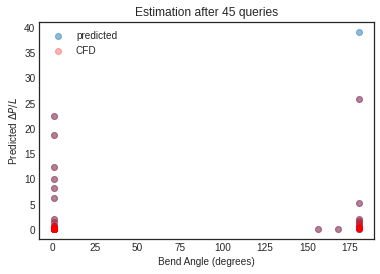

<Figure size 432x288 with 0 Axes>

In [13]:
# plotting after active learning
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(6, 4))
    plt.scatter(Xs[:,1], pred, label='predicted', alpha=0.5)
#     plt.fill_between(x[:, 1], pred-std, pred+std, alpha=0.2)
    plt.scatter(Xs[1:,1], ys[1:], c ='r', label='CFD', alpha=0.3)
    # plt.scatter(X_train[:,1], y_train, c='k', label='CFD calc')
    plt.title(f'Estimation after {N_QUERIES} queries')
    plt.xlabel('Bend Angle (degrees)')
    plt.ylabel(r'Predicted $\Delta P/L$')
    plt.legend()
    plt.show()
    plt.savefig('final_{N_QUERIES}_queries_bendangle.svg')

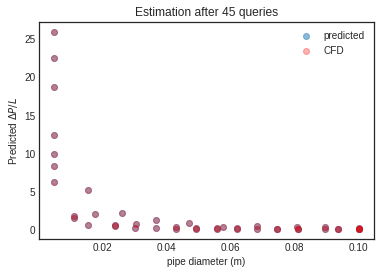

<Figure size 432x288 with 0 Axes>

In [14]:
# plotting after active learning
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(6, 4))
    plt.scatter(Xs[1:,0], pred[1:], label='predicted', alpha=0.5)
#     plt.fill_between(x[:, 0], pred-std, pred+std, alpha=0.2)
    plt.scatter(Xs[1:,0], ys[1:], c ='r', label='CFD', alpha=0.3)
    #plt.scatter(X_raw[:,0], y_raw, c='k', label='CFD calc')
    plt.title(f'Estimation after {N_QUERIES} queries')
    plt.xlabel('pipe diameter (m)')
    plt.ylabel(r'Predicted $\Delta P/L$')
    plt.legend()
    plt.show()
    plt.savefig(f'final_{N_QUERIES}_queries_pipeD.svg')

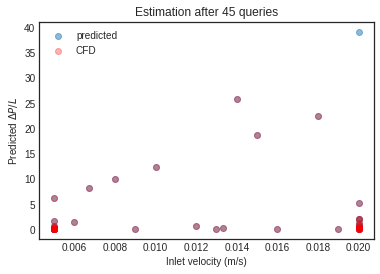

<Figure size 432x288 with 0 Axes>

In [15]:
# plotting after active learning
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(6, 4))
    plt.scatter(Xs[:,2], pred, label='predicted', alpha=0.5)
#     plt.fill_between(x[:, 2], pred-std, pred+std, alpha=0.2)
    plt.scatter(Xs[1:,2], ys[1:], c ='r', label='CFD', alpha=0.3)
#     plt.scatter(X_raw[:,2], y_raw, c='k', label='CFD calc')
    plt.title(f'Estimation after {N_QUERIES} queries')
    plt.xlabel('Inlet velocity (m/s)')
    plt.ylabel(r'Predicted $\Delta P/L$')
    plt.legend()
    plt.show()
    plt.savefig(f'final_{N_QUERIES}_queries_inletV.svg')

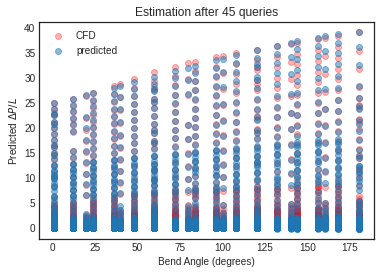

72.29169216098018

<Figure size 432x288 with 0 Axes>

In [16]:
pred_test= regressor_3d.predict(X_pool.reshape(-1,3))
rmse_test = np.sqrt(np.sum((y_pool - pred_test)**2))
# plotting after active learning
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(6, 4))
    plt.scatter(X_pool[:,1], y_pool, c ='r', label='CFD', alpha=0.3)
    plt.scatter(X_pool[:,1], pred_test, label='predicted', alpha=0.5)
#     plt.fill_between(x[:, 1], pred-std, pred+std, alpha=0.2)
    # plt.scatter(X_train[:,1], y_train, c='k', label='CFD calc')
    plt.title(f'Estimation after {N_QUERIES} queries')
    plt.xlabel('Bend Angle (degrees)')
    plt.ylabel(r'Predicted $\Delta P/L$')
    plt.legend()
    plt.show()
    plt.savefig('final_{N_QUERIES}_queries_bendangle.svg')
rmse_test

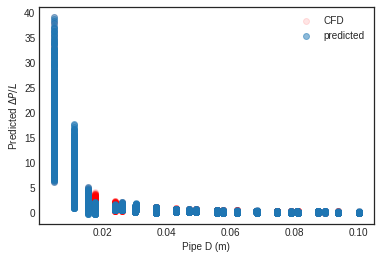

72.29169216098018

<Figure size 432x288 with 0 Axes>

In [17]:
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(6, 4))
    plt.scatter(X_pool[:,0], y_pool, c ='r', label='CFD', alpha=0.1)
    plt.scatter(X_pool[:,0], pred_test, label='predicted', alpha=0.5)
#     plt.fill_between(x[:, 1], pred-std, pred+std, alpha=0.2)
    # plt.scatter(X_train[:,1], y_train, c='k', label='CFD calc')
#     plt.title(f'Estimation after {N_QUERIES} queries')
    plt.xlabel('Pipe D (m)')
    plt.ylabel(r'Predicted $\Delta P/L$')
    plt.legend()
    plt.show()
    plt.savefig('final_{N_QUERIES}_queries_d.svg')

rmse_test = np.sqrt(np.sum((y_pool - pred_test)**2))
rmse_test

## Test analytic function with noise

In [39]:
X = np.linspace(-np.pi, np.pi, 25)

X_raw = np.column_stack((X, X, X))
y_raw = np.sin(X_raw[:,0]) + np.cos(X_raw[:,1]) + np.sin(X_raw[:,2]) + np.random.random(size=X_raw.shape[0])

n_labeled_examples = X_raw.shape[0]
training_indices = np.random.randint(low=0, high=n_labeled_examples, size=5)

X_train = X_raw[training_indices]
y_train = y_raw[training_indices]

# Isolate the non-training examples we'll be querying.
X_pool = np.delete(X_raw, training_indices, axis=0)
y_pool = np.delete(y_raw, training_indices, axis=0)

X_train, y_train

(array([[ 0.78539816,  0.78539816,  0.78539816],
        [-0.78539816, -0.78539816, -0.78539816],
        [-1.83259571, -1.83259571, -1.83259571],
        [-2.0943951 , -2.0943951 , -2.0943951 ],
        [-2.61799388, -2.61799388, -2.61799388]]),
 array([ 2.58959936, -0.53032894, -1.40069386, -2.07159817, -1.58376185]))

In [40]:
def GP_regression_std(regressor, X):
    _, std = regressor.predict(X, return_std=True)
    return np.argmax(std)

kernel = Matern(length_scale=2.0)
regressor = GaussianProcessRegressor(kernel=kernel)

regressor_3d = BayesianOptimizer(
    estimator=regressor,
    query_strategy=max_EI,
    X_training=X_train, y_training=y_train
)

In [41]:
x_1d = np.linspace(-np.pi, np.pi, 1000)
x = np.column_stack((x_1d, x_1d, x_1d))

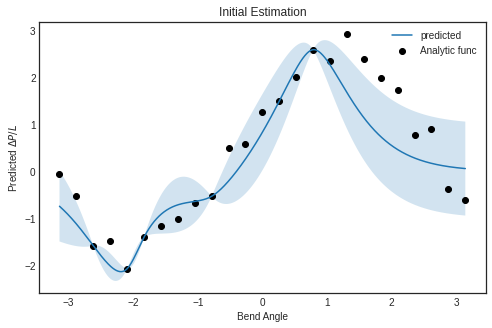

<Figure size 432x288 with 0 Axes>

In [42]:
pred_init, std_init = regressor_3d.predict(x.reshape(-1,3), return_std = True) 

with plt.style.context('seaborn-white'):
    plt.figure(figsize=(8, 5))
    plt.plot(x[:,1], pred_init, label='predicted')
    plt.fill_between(x[:, 1], pred_init-std_init, pred_init+std_init, alpha=0.2)
    plt.scatter(X_raw[:,1], y_raw, c='k', label='Analytic func') # label='CFD calc')
    plt.title('Initial Estimation')
    plt.xlabel('Bend Angle')
    plt.ylabel(r'Predicted $\Delta P/L$')
    plt.legend()
    plt.show()
    plt.savefig('Init_known_func.svg')

In [43]:
N_QUERIES = 10
#performance_history = [unqueried_score]

# Allow our model to query our unlabeled dataset for the most
# informative points according to our query strategy (uncertainty sampling).
for index in range(N_QUERIES):
    query_index, query_instance = regressor_3d.query(X_pool)

    # Teach our ActiveLearner model the record it has requested.
    X, y = X_pool[query_index].reshape(-1, 3), y_pool[query_index].reshape(1, )
    regressor_3d.teach(X=X, y=y)

    # Remove the queried instance from the unlabeled pool.
    X_pool, y_pool = np.delete(X_pool, query_index, axis=0), np.delete(y_pool, query_index)

    # Calculate and report our model's accuracy.
    model_accuracy = regressor_3d.score(X_raw.reshape(-1,3), y_raw.reshape(-1, 1))
    print('Accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))

    # Save our model's performance for plotting.
    #performance_history.append(model_accuracy)

Accuracy after query 1: 0.8467
Accuracy after query 2: 0.8364
Accuracy after query 3: 0.9114
Accuracy after query 4: 0.9019
Accuracy after query 5: 0.9164
Accuracy after query 6: 0.9437
Accuracy after query 7: 0.9630
Accuracy after query 8: 0.9627
Accuracy after query 9: 0.9750
Accuracy after query 10: 0.9701


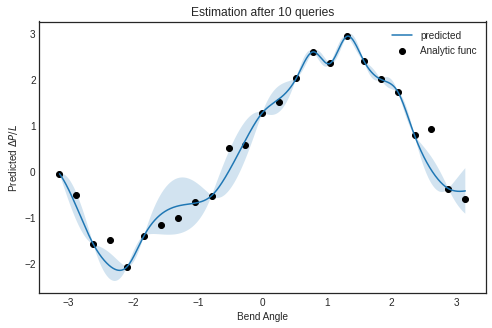

<Figure size 432x288 with 0 Axes>

In [44]:
pred_final, std_final = regressor_3d.predict(x.reshape(-1,3), return_std = True) 

with plt.style.context('seaborn-white'):
    plt.figure(figsize=(8, 5))
    plt.plot(x[:,1], pred_final, label='predicted')
    plt.fill_between(x[:, 1], pred_final-std_final, pred_final+std_final, alpha=0.2)
    plt.scatter(X_raw[:,1], y_raw, c='k', label='Analytic func') # label='CFD calc')
    plt.title(f'Estimation after {N_QUERIES} queries')
    plt.xlabel('Bend Angle')
    plt.ylabel(r'Predicted $\Delta P/L$')
    plt.legend()
    plt.show()
    plt.savefig('Init_known_func.svg')